# CICE Arctic Sample Project


In this notebook, the code has the simplest regional ocean model setup possible through CrocoDash. In the comments and descriptions, we'll provide some of the ways you can add and build on this demo (recreate a specific domain - like GFDL's NWA12, run with CICE - the sea-ice model in CESM, run with MARBL - the ocean BGC model in CESM, and beyond!) 

This notebook is designed for new users of CrocoDash and CESM who want to set up a simple regional ocean model. By following the steps, you will learn how to generate a domain, configure a CESM case, prepare ocean forcing data, and run your simulation.


A typical workflow of utilizing CrocoDash consists of four main steps:

1. Generate a regional MOM6 domain.
2. Create the CESM case.
3. Prepare ocean forcing data.
4. Build and run the case.

Every specialization of CrocoDash will use this framework.


# SECTION 1: Generate a regional MOM6 domain

We begin by defining a regional MOM6 domain using CrocoDash. To do so, we first generate a horizontal grid. We then generate the topography by remapping an existing bathymetric dataset to our horizontal grid. Finally, we define a vertical grid.

## Step 1.1: Horizontal Grid

CROCODILE grid generator tools cannot create domains over the poles (but will soon!), instead we pass in previously generated grids over the Artic/Antartic (If you're interested in how we generated these, please reach out!). 
As a quick reminder, sea ice OBCs are not well understood, and it is common practice to have a domain where sea ice does not reach the boundaries. 

Grids:
- Arctic Grid: /glade/campaign/cgd/oce/projects/CROCODILE/workshops/2025/CrocoDash/grids/cice_grids/replica_grid_3413.nc 
- Arctic Bathy: /glade/campaign/cgd/oce/projects/CROCODILE/workshops/2025/CrocoDash/grids/cice_grids/bathy_3413.nc 
- Antarctic Grid: /glade/campaign/cgd/oce/projects/CROCODILE/workshops/2025/CrocoDash/grids/cice_grids/replica_grid_3031.nc 
- Antarctic Bathy: /glade/campaign/cgd/oce/projects/CROCODILE/workshops/2025/CrocoDash/grids/cice_grids/bathy_3031.nc

In [1]:
from CrocoDash.grid import Grid

grid = Grid.from_supergrid("/glade/campaign/cgd/oce/projects/CROCODILE/workshops/2025/CrocoDash/grids/cice_grids/replica_grid_3413.nc")
grid.name = "Arctic_Grid"

The above cell is a way to generate a rectangular lat/lon grid through CrocoDash

If you're interested in using an already generated regional grid, you can do that by passing in a supergrid, like in [this demo](https://crocodile-cesm.github.io/CrocoGallery/notebooks/features/add_grids.html).

If you're interested in subsetting an already generated global grid, you can do that by passing in lat/lon args, like in [this demo](https://crocodile-cesm.github.io/CrocoGallery/notebooks/features/subset_global.html).

## Step 1.2: Topography

The below three cells are a way to generate topography with a given grid using the [GEBCO](https://www.gebco.net/) dataset. 

If you're interested in using a previously generated topography for your grid, you can do that by passing in a topography file, like in [this demo.](https://crocodile-cesm.github.io/CrocoGallery/notebooks/features/add_grids.html)

In [2]:
from CrocoDash.topo import Topo

bathymetry_path='/glade/campaign/cgd/oce/projects/CROCODILE/workshops/2025/CrocoDash/grids/cice_grids/bathy_3413.nc'

topo = Topo.from_topo_file(
    grid = grid,
    topo_file_path=bathymetry_path,
    min_depth = 9.5,
)

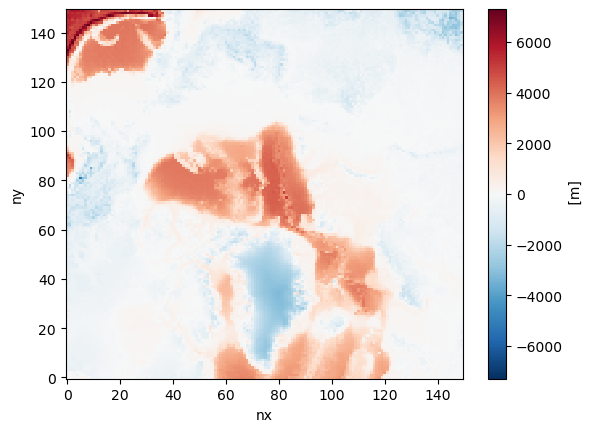

In [3]:
# Validate that the topography looks right!
topo.depth.plot()

## Step 1.3: Vertical Grid

The below cell generates a vertical grid using a hyperbolic function. We can also create a uniform grid instance, or use a previously generated vertical grid, like in [this demo.](https://crocodile-cesm.github.io/CrocoGallery/notebooks/features/add_grids.html)

In [4]:
from CrocoDash.vgrid import VGrid

vgrid  = VGrid.hyperbolic(
    nk = 75, # number of vertical levels
    depth = topo.max_depth,
    ratio=20.0 # target ratio of top to bottom layer thicknesses
)

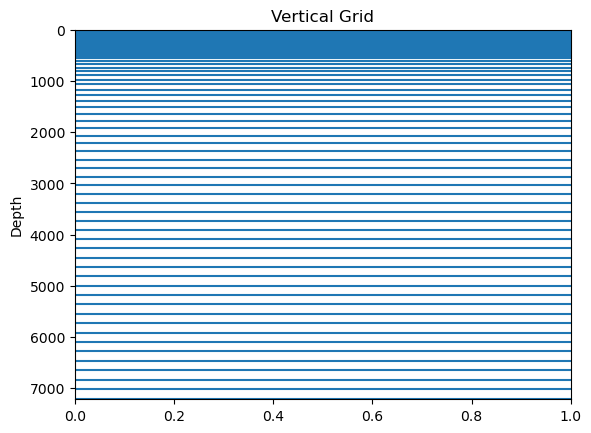

In [5]:
import matplotlib.pyplot as plt
plt.close()
# Create the plot
for depth in vgrid.z:
    plt.axhline(y=depth, linestyle='-')  # Horizontal lines

plt.ylim(max(vgrid.z) + 10, min(vgrid.z) - 10)  # Invert y-axis so deeper values go down
plt.ylabel("Depth")
plt.title("Vertical Grid")
plt.show()

# SECTION 2: Create the CESM case

After generating the MOM6 domain, the next step is to create a CESM case using CrocoDash. This process is straightforward and involves instantiating the CrocoDash Case object. The Case object requires the following inputs:

 - CESM Source Directory: A local path to a compatible CESM source copy.
 - Case Name: A unique name for the CESM case.
 - Input Directory: The directory where all necessary input files will be written.
 - MOM6 Domain Objects: The horizontal grid, topography, and vertical grid created in the previous section.
 - Project ID: (Optional) A project ID, if required by the machine.
 - Compset: The set of models to be used in the Case. Standalone Ocean, Ocean-BGC, Ocean-Seaice, Ocean-Runoff, etc...

## Step 2.1: Specify case name and directories:

Begin by specifying the case name and the necessary directory paths. Ensure the CESM root directory points to your own local copy of CESM. Below is an example setup:

In [6]:
from pathlib import Path

In [7]:
# CESM case (experiment) name
casename = "arctic.cice.1"

# CESM source root (Update this path accordingly!!!)
cesmroot ="/glade/work/mlevy/codes/CESM/cesm3_0_alpha07c_CROCO/"

# Place where all your input files go 
inputdir = Path.home()/"scratch" / "croc_input" / casename
    
# CESM case directory
caseroot = Path.home() / "croc_cases" / casename

## Step 2.2: Create the Case

To create the CESM case, instantiate the `Case` object as shown below. This will automatically set up the CESM case based on the provided inputs: The `cesmroot` argument specifies the path to your local CESM source directory.
The `caseroot` argument defines the directory where the case will be created. CrocoDash will handle all necessary namelist modifications and XML changes to align with the MOM6 domain objects generated earlier.


This is where we can change the model setup to what we want:
 - Interested in BGC? Check out [the demo for how to modify this notebook for BGC.](https://crocodile-cesm.github.io/CrocoGallery/notebooks/features/add_bgc.html)
 - Interested in CICE? Check out [the demo for how to modify this notebook for CICE.](https://crocodile-cesm.github.io/CrocoGallery/notebooks/features/add_cice.html)
 - Interested in Data Runoff from GLOFAS (or JRA)? Check out [the demo for how to modify this notebook for Data Runoff.](https://crocodile-cesm.github.io/CrocoGallery/notebooks/features/add_rof.html)

In [8]:
from CrocoDash.case import Case

case = Case(
    cesmroot = cesmroot,
    caseroot = caseroot,
    inputdir = inputdir,
    ocn_grid = grid,
    ocn_vgrid = vgrid,
    ocn_topo = topo,
    project = 'ncgd0011',
    override = True,
    machine = "derecho",
    compset = "1850_DATM%JRA_SLND_CICE_MOM6_SROF_SGLC_SWAV" # Change this as necessary to include whatever models you want. BGC? change MOM6 to MOM6%MARBL-BIO, CICE? Change SICE to CICE, GLOFAS Runoff? Change SROF to DROF%GLOFAS
)

INFO:  csp_solver:CspSolver initialized.


Creating case...

• Updating ccs_config/modelgrid_aliases_nuopc.xml file to include the new resolution "arctic.cice.1" consisting of the following component grids.
 atm grid: "TL319", lnd grid: "TL319", ocn grid: "Arctic_Grid".

• Updating ccs_config/component_grids_nuopc.xml file to include newly generated ocean grid "Arctic_Grid" with the following properties:
 nx: 150, ny: 150. ocean mesh: /glade/u/home/manishrv/scratch/croc_input/arctic.cice.1/ocnice/ESMF_mesh_Arctic_Grid_e66a78.nc.

Running the create_newcase tool with the following command:

/glade/work/mlevy/codes/CESM/cesm3_0_alpha07c_CROCO/cime/scripts/create_newcase --compset 1850_DATM%JRA_SLND_CICE_MOM6_SROF_SGLC_SWAV --res arctic.cice.1 --case /glade/u/home/manishrv/croc_cases/arctic.cice.1 --machine derecho --run-unsupported --project ncgd0011 --non-local 

The create_newcase command was successful.

Navigating to the case directory:

cd /glade/u/home/manishrv/croc_cases/arctic.cice.1

Apply NTASK grid xml changes:

./xmlc

INFO:	stage:SUCCESS: All stages are complete.


Case created successfully at /glade/u/home/manishrv/croc_cases/arctic.cice.1.

To further customize, build, and run the case, navigate to the case directory in your terminal. To create another case, restart the notebook.

./xmlchange MOM6_MEMORY_MODE=dynamic_symmetric --non-local

./xmlchange ROOTPE_OCN=128 --non-local



# Section 3: Prepare ocean forcing data

We need to cut out our ocean forcing. The package expects an initial condition and one time-dependent segment per non-land boundary.

In this notebook, we are forcing with the Copernicus Marine "Glorys" reanalysis dataset.

## Step 3.1 Configure Initial Conditions and Forcings

 - Interested in adding tides? Check out [the demo.](https://crocodile-cesm.github.io/CrocoGallery/notebooks/features/add_tides.html)
 - Interested in adding chlorophyll? Check out [the demo.](https://crocodile-cesm.github.io/CrocoGallery/notebooks/features/add_chl.html)
 - Is the GLORYS data access function not working? Check out alternative options in [this demo.](https://crocodile-cesm.github.io/CrocoGallery/notebooks/features/add_data_products.html)

Configure Forcings MUST be modified if BGC or Data Runoff are part of the compset (and will throw an error). Check out the demos to see the changes required: [BGC Demo](https://crocodile-cesm.github.io/CrocoGallery/notebooks/features/add_bgc.html), [DROF Demo](https://crocodile-cesm.github.io/CrocoGallery/notebooks/features/add_rof.html).


In [9]:
case.configure_forcings(
    date_range = ["2020-01-01 00:00:00", "2020-01-06 00:00:00"],
    product_name = "GLORYS",
    function_name="get_glorys_data_from_rda")

INFO:CrocoDash.raw_data_access.datasets.glorys:Downloading Glorys data from RDA to /glade/derecho/scratch/manishrv/tmp/tmppk8n9k1m/test_file.nc
INFO:CrocoDash.raw_data_access.datasets.glorys:Downloading Glorys data from RDA to /glade/derecho/scratch/manishrv/tmp/tmp4s526_mt/test_file.nc
INFO:get_dataset_piecewise:Downloading GLORYS data using get_glorys_data_from_rda from 2020-01-01 00:00:00 to 2020-01-06 00:00:00.
INFO:get_dataset_piecewise:Using step size 6, this will result in 1 files per boundary.
INFO:CrocoDash.raw_data_access.datasets.glorys:Downloading Glorys data from RDA to /glade/u/home/manishrv/scratch/croc_input/arctic.cice.1/glorys/large_data_workflow/raw_data/ic_unprocessed.nc
INFO:CrocoDash.raw_data_access.datasets.glorys:Downloading Glorys data from RDA to /glade/u/home/manishrv/scratch/croc_input/arctic.cice.1/glorys/large_data_workflow/raw_data/south_unprocessed.20200101_20200106.nc
INFO:CrocoDash.raw_data_access.datasets.glorys:Downloading Glorys data from RDA to /gl

Adding parameter changes to user_nl_mom:

  ! Initial conditions
  INIT_LAYERS_FROM_Z_FILE = True
  Z_INIT_ALE_REMAPPING = True
  TEMP_SALT_INIT_VERTICAL_REMAP_ONLY = True
  DEPRESS_INITIAL_SURFACE = True
  VELOCITY_CONFIG = file
  TEMP_SALT_Z_INIT_FILE = init_tracers.nc
  SURFACE_HEIGHT_IC_FILE = init_eta.nc
  SURFACE_HEIGHT_IC_VAR = eta_t
  VELOCITY_FILE = init_vel.nc
  Z_INIT_FILE_PTEMP_VAR = temp

  ! Open boundary conditions
  OBC_NUMBER_OF_SEGMENTS = 4
  OBC_FREESLIP_VORTICITY = False
  OBC_FREESLIP_STRAIN = False
  OBC_COMPUTED_VORTICITY = True
  OBC_COMPUTED_STRAIN = True
  OBC_ZERO_BIHARMONIC = True
  OBC_TRACER_RESERVOIR_LENGTH_SCALE_OUT = 3.0E+04
  OBC_TRACER_RESERVOIR_LENGTH_SCALE_IN = 3000.0
  BRUSHCUTTER_MODE = True
  OBC_SEGMENT_001 = "J=0,I=0:N,FLATHER,ORLANSKI,NUDGED,ORLANSKI_TAN,NUDGED_TAN"
  OBC_SEGMENT_001_VELOCITY_NUDGING_TIMESCALES = 0.3, 360.0
  OBC_SEGMENT_001_DATA = "U=file:forcing_obc_segment_001.nc(u),V=file:forcing_obc_segment_001.nc(v),SSH=file:forcing_obc_

##  Step 3.3: Process forcing data

In this final step, we call the `process_forcings` method of CrocoDash to cut out and interpolate the initial condition as well as all boundaries. CrocoDash also updates MOM6 runtime parameters and CESM xml variables accordingly.

In [10]:
case.process_forcings() # You can turn off specific processing if it's already been processed previously with process_*name* = False. Ex. case.process_forcings(process_chl = False)

INFO:regrid_dataset_piecewise:Parsing Raw Data Folder
INFO:regrid_dataset_piecewise:All boundaries continuous and non-overlapping.
INFO:regrid_dataset_piecewise:Setting up required information
INFO:regrid_dataset_piecewise:Starting regridding
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Creating Regridder


Processing north boundary velocity & tracers...

INFO:regional_mom6.rotation:Getting rotation angle
INFO:regional_mom6.rotation:Calculating grid rotation angle
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Adding time dimension
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in salt_segment_002
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to salt_segment_002
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in temp_segment_002
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to temp_segment_002
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in u_segment_002
INFO:regional_mom6.regridding:Replacing old depth coordinates with incr

Done.
Processing west boundary velocity & tracers...

INFO:regional_mom6.rotation:Getting rotation angle
INFO:regional_mom6.rotation:Calculating grid rotation angle
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Adding time dimension
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in salt_segment_003
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to salt_segment_003
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in temp_segment_003
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to temp_segment_003
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in u_segment_003
INFO:regional_mom6.regridding:Replacing old depth coordinates with incr

Done.
Processing south boundary velocity & tracers...

INFO:regional_mom6.rotation:Getting rotation angle
INFO:regional_mom6.rotation:Calculating grid rotation angle
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Adding time dimension
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in salt_segment_001
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to salt_segment_001
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in temp_segment_001
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to temp_segment_001
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in u_segment_001
INFO:regional_mom6.regridding:Replacing old depth coordinates with incr

Done.
Processing east boundary velocity & tracers...

INFO:regional_mom6.rotation:Getting rotation angle
INFO:regional_mom6.rotation:Calculating grid rotation angle
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Adding time dimension
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in salt_segment_004
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to salt_segment_004
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in temp_segment_004
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to temp_segment_004
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in u_segment_004
INFO:regional_mom6.regridding:Replacing old depth coordinates with incr

Done.
This means that some areas may only have one or two layers between the surface and sea floor. 
For increased stability, consider increasing the minimum depth, or adjusting the vertical coordinate to add more layers near the surface.


INFO:regional_mom6.regridding:Getting t points..
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.rotation:Getting rotation angle
INFO:regional_mom6.rotation:Calculating grid rotation angle


Setting up Initial Conditions
Regridding Velocities... 

INFO:regional_mom6.regridding:Getting u points..
INFO:regional_mom6.regridding:Getting v points..


Done.
Regridding Tracers... Done.
Regridding Free surface... Done.
Saving outputs... 

INFO:regrid_dataset_piecewise:Finished regridding
INFO:merge_piecewise_dataset:Parsing Regridded Data Folder
INFO:merge_piecewise_dataset:All boundaries continuous and non-overlapping.
INFO:merge_piecewise_dataset:Merging Files
INFO:merge_piecewise_dataset:Saved 001 boundary at /glade/u/home/manishrv/scratch/croc_input/arctic.cice.1/ocnice/forcing_obc_segment_001.nc


done setting up initial condition.


INFO:merge_piecewise_dataset:Saved 004 boundary at /glade/u/home/manishrv/scratch/croc_input/arctic.cice.1/ocnice/forcing_obc_segment_004.nc
INFO:merge_piecewise_dataset:Saved 002 boundary at /glade/u/home/manishrv/scratch/croc_input/arctic.cice.1/ocnice/forcing_obc_segment_002.nc
INFO:merge_piecewise_dataset:Saved 003 boundary at /glade/u/home/manishrv/scratch/croc_input/arctic.cice.1/ocnice/forcing_obc_segment_003.nc


Case is ready to be built: /glade/u/home/manishrv/croc_cases/arctic.cice.1


# Section 4: Build and run the case

After completing the previous steps, you are ready to build and run your CESM case. Begin by navigating to the case root directory specified during the case creation. Before proceeding, review the `user_nl_mom` file located in the case directory. This file contains MOM6 parameter settings that were automatically generated by CrocoDash. Carefully examine these parameters and make any necessary adjustments to fine-tune the model for your specific requirements. While CrocoDash aims to provide a solid starting point, further tuning and adjustments are typically necessary to improve the model for your use case.

Once you have reviewed and modified the parameters as needed, you can build and execute the case using the following commands: 
```
qcmd -- ./case.build
./case.submit
```

## Optional: Use restart files as initial condition for your run (after you run for the first time!)

In case you want to start the model with a restart file instead of using the generated initial condition, follow the below steps. Note that you have to have finished a run beforehand for the restart files to appear.
1. Locate your restart file - they are usually in your previous case's `/archive/rest/<year>` folder with a `.r` infix, e.g., `cice.test.cice.r.1994-01-01-00000.nc`.
   If you do not know your `/archive` folder location, run `./xmlquery DOUT_S_ROOT` in your (previous) case folder, which will return a path similar to `DOUT_S_ROOT: <PATH TO ARCHIVE>`.

2. Use the `cp` command to copy the file to your current case `/run` directory, e.g., `cp cice.test.cice.r.1994-01-01-00000.nc <your_run_dir>`.
3. Open `user_nl_cice` in your case directory again and change the `ice_ic` variable from `"UNSET"` to your file name, e.g., `ice_ic=cice.test.cice.r.1994-01-01-00000.nc`

Your file will now be used automatically as the ice initial condition for your next run. Note that `.h` and `.h1` files (i.e. history files) currently **cannot be used** as initial conditions for CICE.